In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [3]:
# ----------------------------
# 1. 加载并预处理数据
# ----------------------------
df = pd.read_excel(r'./datasets/AlibabaStock2021-2023.xlsx')

# 清理列名（去除可能的空格或重复标题行）
df = df.dropna(subset=['日期'])  # 去掉因重复标题产生的 NaN 行
df = df.reset_index(drop=True)

# 确保列顺序正确（根据你提供的数据）
cols = ['开盘价', '最高价', '最低价', '收盘价', '成交量']
data = df[cols].values.astype(np.float32)

# 标准化（只用训练部分拟合 scaler，但为简单起见，这里全局标准化）
scaler_features = StandardScaler()
scaler_target = StandardScaler()

# 分别标准化特征和目标（目标只用收盘价）
features_scaled = scaler_features.fit_transform(data)  # (N, 5)
target_scaled = scaler_target.fit_transform(data[:, [3]])  # 收盘价，(N, 1)

In [4]:
# ----------------------------
# 2. 构建滑动窗口数据集
# ----------------------------
class StockDataset(Dataset):
    def __init__(self, features, target, history=30, delay=2):
        """
        features: (N, 5) 标准化后的特征
        target:   (N, 1) 标准化后的收盘价
        history:  输入序列长度（30天）
        delay:    预测未来第 delay 天（这里 delay=2）
        """
        self.features = features
        self.target = target
        self.history = history
        self.delay = delay
        self.len = len(features) - history - delay + 1

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x = self.features[idx : idx + self.history]  # (30, 5)
        y = self.target[idx + self.history + self.delay - 1].item()  # scalar
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 参数
HISTORY = 30
DELAY = 2
BATCH_SIZE = 16

dataset = StockDataset(features_scaled, target_scaled, history=HISTORY, delay=DELAY)

# 划分训练/验证（按时间顺序，不打乱）
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = total_len - train_len

train_dataset = torch.utils.data.Subset(dataset, range(train_len))
val_dataset = torch.utils.data.Subset(dataset, range(train_len, total_len))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:

# ----------------------------
# 3. 定义 LSTM 模型
# ----------------------------
class LSTMStockPredictor(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len=30, input_dim=5)
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # 取最后一个时间步
        return out.squeeze(-1)  # (batch,)

In [6]:
# ----------------------------
# 4. 训练函数
# ----------------------------
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    return train_losses, val_losses

In [7]:
# ----------------------------
# 5. 训练模型
# ----------------------------
model = LSTMStockPredictor(input_dim=5, hidden_dim=64, num_layers=2)
print("Start training...")
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, lr=1e-3)

Start training...
Epoch 20/100, Train Loss: 0.031697, Val Loss: 0.015839
Epoch 40/100, Train Loss: 0.026752, Val Loss: 0.012859
Epoch 60/100, Train Loss: 0.046982, Val Loss: 0.012087
Epoch 80/100, Train Loss: 0.034311, Val Loss: 0.007416
Epoch 100/100, Train Loss: 0.032711, Val Loss: 0.007586


In [8]:

# ----------------------------
# 6. 评估（反标准化后计算 MAE）
# ----------------------------
def evaluate(model, data_loader, scaler_target):
    device = next(model.parameters()).device
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            preds.append(pred.cpu().numpy())
            trues.append(y.cpu().numpy())

    preds = np.concatenate(preds).reshape(-1, 1)
    trues = np.concatenate(trues).reshape(-1, 1)

    # 反标准化
    preds_real = scaler_target.inverse_transform(preds)
    trues_real = scaler_target.inverse_transform(trues)

    mae = np.mean(np.abs(preds_real - trues_real))
    rmse = np.sqrt(np.mean((preds_real - trues_real) ** 2))
    return mae, rmse, preds_real, trues_real

mae, rmse, preds, trues = evaluate(model, val_loader, scaler_target)
print(f"\nValidation Results:")
print(f"MAE:  {mae:.4f} CNY")
print(f"RMSE: {rmse:.4f} CNY")




Validation Results:
MAE:  3.9979 CNY
RMSE: 5.0800 CNY


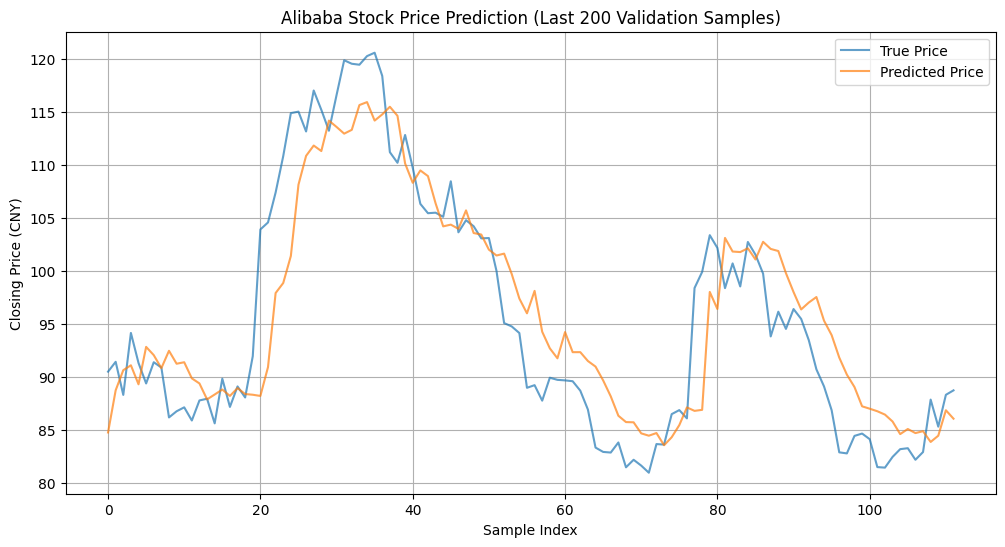

In [9]:
# ----------------------------
# 7. 可视化预测 vs 真实值
# ----------------------------
plt.figure(figsize=(12, 6))
plt.plot(trues[-200:], label='True Price', alpha=0.7)
plt.plot(preds[-200:], label='Predicted Price', alpha=0.7)
plt.title('Alibaba Stock Price Prediction (Last 200 Validation Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Closing Price (CNY)')
plt.legend()
plt.grid(True)
plt.show()